##  Importing Dependencies
   We shall start by importing all the neccessary libraries. I will explain the exact use of each library later in this notebook.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import re

print("Tensorflow Version",tf.__version__)

C:\Users\CZ\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\CZ\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\CZ\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\CZ\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1)

Tensorflow Version 1.14.0


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CZ\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#  Dataset Preprocessing
In this notebook, I am using **Sentiment-140** from [Kaggle](https://www.kaggle.com/kazanova/sentiment140). It contains a labels data of 1.6 Million Tweets and I find it a good amount of data to train our model.

In [2]:
df = pd.read_csv('All_News.csv')
df = df.dropna()
df = df.reset_index()
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Date'])
df = df.reset_index()
df = df.drop(columns=['level_0','index'])
df.head()

,Date,News,Polarity,Sentiment,neg,neu,pos,compound,Cum
0,2011-01-04,Bone marrow recipients highlight consequences ...,0,0,0.248,0.560,0.192,-0.1779,0
1,2011-01-04,Zardari signs reference to reopen case of Bhut...,0,0,0.000,1.000,0.000,0.0000,0
2,2011-01-06,Grade 21 officer to head NDMA,0,0,0.000,1.000,0.000,0.0000,0
3,2011-01-06,'Pakistan risks becoming a polio transmission ...,0,0,0.296,0.704,0.000,-0.2732,0
4,2011-01-06,2009: US considers journalist’s request for in...,0,0,0.000,1.000,0.000,0.0000,0


You can see the columns are without any proper names. Lets rename them for our reference

In [3]:
df.describe()

,Polarity,Sentiment,neg,neu,pos,compound,Cum
count,10515.000000,10515.000000,10515.000000,10515.000000,10515.000000,10515.000000,10515.000000
mean,0.167000,0.167000,0.076030,0.830364,0.093605,0.087019,0.167000
std,0.799274,0.799274,0.124271,0.140714,0.109041,0.501812,0.799274
min,-1.000000,-1.000000,0.000000,0.099000,0.000000,-0.979900,-1.000000
25%,0.000000,0.000000,0.000000,0.750000,0.000000,-0.296000,0.000000
50%,0.000000,0.000000,0.000000,0.845000,0.071000,0.000000,0.000000
75%,1.000000,1.000000,0.128000,0.934000,0.161000,0.510600,1.000000
max,1.000000,1.000000,0.821000,1.000000,0.773000,0.973200,1.000000


We are going to train only on text to classify its sentiment. So we can ditch the rest of the useless columns.

In [4]:
output = df.iloc[int(len(df)*0.8):]
output.describe()


,Polarity,Sentiment,neg,neu,pos,compound,Cum
count,2103.000000,2103.000000,2103.000000,2103.000000,2103.000000,2103.000000,2103.000000
mean,0.214931,0.214931,0.061819,0.846333,0.091841,0.119874,0.214931
std,0.779388,0.779388,0.098741,0.122304,0.097534,0.501441,0.779388
min,-1.000000,-1.000000,0.000000,0.227000,0.000000,-0.972900,-1.000000
25%,0.000000,0.000000,0.000000,0.769000,0.000000,-0.173700,0.000000
50%,0.000000,0.000000,0.000000,0.858000,0.078000,0.025800,0.000000
75%,1.000000,1.000000,0.100000,0.940000,0.151000,0.542300,1.000000
max,1.000000,1.000000,0.587000,1.000000,0.773000,0.963800,1.000000


In [5]:
df['Polarity'].value_counts()


 1    4383
 0    3505
-1    2627
Name: Polarity, dtype: int64

Here are decoding the labels. We map **0 -> Negative and 1 -> Positive** as directed by the datset desciption. Now that we decoded we shall now analyse the dataset by its distribution. Because it's important that we have almost small amount of examples for given classes.

Positive: 4383 , Negative: 2627 , Neutral: 3505


Text(0.5, 1.0, 'Sentiment Data Distribution')

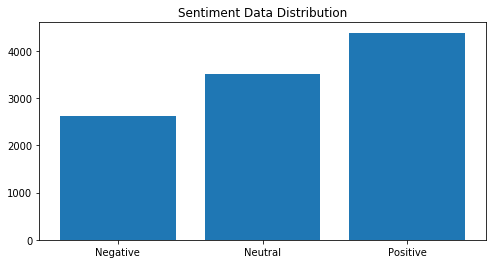

In [6]:
plt.figure(figsize=(8,4))
count_pos = df['Polarity'].value_counts()[1]
count_ntl = df['Polarity'].value_counts()[0]
count_neg = df['Polarity'].value_counts()[-1]

print('Positive:', count_pos, ',', 'Negative:', count_neg, ',', 'Neutral:', count_ntl)

plt.bar(['Negative', 'Neutral', 'Positive'], [count_neg, count_ntl, count_pos])
plt.title("Sentiment Data Distribution")

It's a very good dataset without any skewness. Thank Goodness.

Now let us explore the data we having here... 

In [7]:
import random
random_idx_list = [random.randint(1,len(df)) for i in range(10)] # creates random indexes to choose from dataframe
df.loc[random_idx_list,:].head(10) # Returns the rows with the index and display it

,Date,News,Polarity,Sentiment,neg,neu,pos,compound,Cum
828,2012-12-16,PA session on Monday - LAHORE: The Punjab Asse...,0,0,0.000,1.000,0.000,0.0000,0
10503,2021-11-01,Balochistan govt initiated development schemes...,0,0,0.000,1.000,0.000,0.0000,0
118,2011-05-30,Shahid Afridi retires from international cricket,0,0,0.000,1.000,0.000,0.0000,0
1006,2013-05-09,New BB Airport case: CJP says court embarrasse...,0,0,0.068,0.840,0.092,0.2263,0
10138,2020-11-21,COVID-19 claims 15 more lives in Punjab on Sat...,0,0,0.000,1.000,0.000,0.0000,0
4717,2017-11-23,Brazil's inflation rate hits 5-month high but ...,-1,-1,0.111,0.889,0.000,-0.5023,-1
1903,2014-09-16,All parties have to shed egoism to safeguard c...,1,1,0.000,0.757,0.243,0.7506,1
8446,2020-04-15,"Lockdown in province will be more intense, war...",1,1,0.050,0.797,0.153,0.5446,1
3138,2016-02-03,"COAS meets Afghan president, top US defence le...",0,0,0.000,0.738,0.262,0.2960,0
6626,2019-08-04,"China lowers tariffs on computers, bikes, othe...",-1,-1,0.129,0.871,0.000,-0.4019,-1


### Stemming/ Lematization
For grammatical reasons, documents are going to use different forms of a word, such as *write, writing and writes.* Additionally, there are families of derivationally related words with similar meanings. The goal of both stemming and lemmatization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form.

Stemming usually refers to a process that chops off the ends of words in the hope of achieving goal correctly most of the time and often includes the removal of derivational affixes. 

Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base and dictionary form of a word
![Stemming and Lematization](https://qph.fs.quoracdn.net/main-qimg-cd7f4bafaa42639deb999b1580bea69f)

### Hyperlinks and Mentions
Twitter is a social media platform where people can tag and mentions other people's ID and share videos and blogs from internet. So the tweets often contain lots of Hyperlinks and twitter mentions.

- Twitter User Mentions - Eg. @arunrk7, @andrewng
- Hyperlinks - Eg. https://keras.io, https://tensorflow.org

### Stopwords
Stopwords are commonly used words in English which have no contextual meaning in an sentence. So therefore we remove them before classification. Some stopwords are...
![Stopwords English](https://4.bp.blogspot.com/-yiEr-jCVv38/Wmk10d84DYI/AAAAAAAAk0o/IfgjfjpgrxM5NosUQrGw7PtLvgr6DAG8ACLcBGAs/s1600/Screen%2BShot%2B2018-01-24%2Bat%2B5.41.21%2BPM.png)

That looks like a tedious process, isn't?. Don't worry there is always some library in Python to do almost any work. The world is great!!!

**NLTK** is a python library which got functions to perform text processing task for NLP.



In [8]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [9]:
def preprocess(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [10]:
df.text = df['News'].apply(lambda x: preprocess(x))

C:\Users\CZ\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [11]:
df.tail()

,Date,News,Polarity,Sentiment,neg,neu,pos,compound,Cum
10510,2021-12-01,Court postpones Gilani's indictment till Febru...,0,0,0.07,0.930,0.000,-0.2732,0
10511,2021-12-01,Commissioner inaugurates anti-polio campaign -...,0,0,0.00,1.000,0.000,0.0000,0
10512,2021-12-01,Anti-polio campaign in full swing - Hussain in...,0,0,0.00,1.000,0.000,0.0000,0
10513,2021-12-01,Procurement of COVID vaccine will take some ti...,0,0,0.00,0.972,0.028,0.0772,0
10514,2021-12-01,Former model Frieha Altaf is the latest target...,0,0,0.00,1.000,0.000,0.0000,0


**Aaww.. It is clean and tidy now. Now let's see some word cloud visualizations of it.**

### Positive Words

            Date                                               News  Polarity  \
2770  2015-08-26  Stock wobbles persist despite China rate cut -...         1   
3602  2016-07-03  Saudi investors keen in investment, joint vent...         1   
6966  2019-11-10  AkzoNobel introduces Dulux weathershield - Akz...         1   
6967  2019-11-10  Multimodal transport service via train initiat...         1   
3620  2016-07-11  Rice export orders to bring relief to farmers ...         1   
...          ...                                                ...       ...   
1958  2014-10-05  Home work completed to introduce Arabic langua...         1   
9956  2020-10-23  Civil awards: Senate body dismayed at lack of ...         0   
5600  2018-08-14  Junoon has a new video out for their old class...         0   
10389 2021-01-19  Faisal Javed terms PDM protest another attempt...         0   
10388 2021-01-19  Federal Cabinet constitutes inquiry committee ...         0   

       Sentiment    neg    

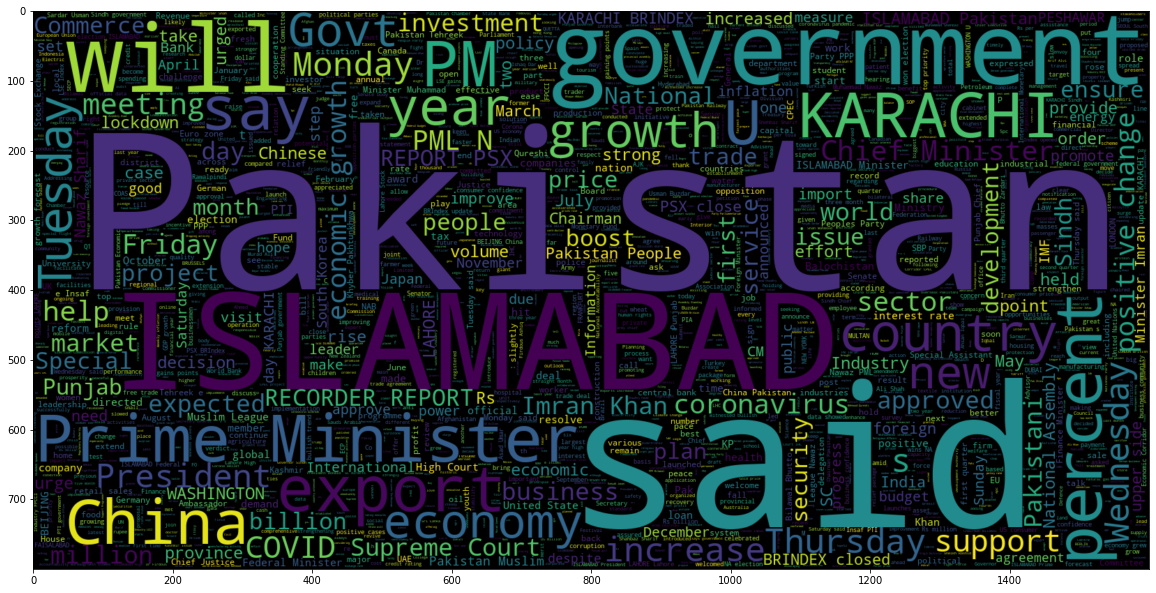

In [12]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 

temp = df.sort_values(by=['Polarity'], ascending = False)
print(temp[0:count_pos+4])
text = ' '.join(temp["News"][0:count_pos])


    
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(text)
plt.imshow(wc , interpolation = 'bilinear')

In [13]:
df.head()

,Date,News,Polarity,Sentiment,neg,neu,pos,compound,Cum
0,2011-01-04,Bone marrow recipients highlight consequences ...,0,0,0.248,0.560,0.192,-0.1779,0
1,2011-01-04,Zardari signs reference to reopen case of Bhut...,0,0,0.000,1.000,0.000,0.0000,0
2,2011-01-06,Grade 21 officer to head NDMA,0,0,0.000,1.000,0.000,0.0000,0
3,2011-01-06,'Pakistan risks becoming a polio transmission ...,0,0,0.296,0.704,0.000,-0.2732,0
4,2011-01-06,2009: US considers journalist’s request for in...,0,0,0.000,1.000,0.000,0.0000,0


### Neutral Words

            Date                                               News  Polarity  \
9956  2020-10-23  Civil awards: Senate body dismayed at lack of ...         0   
5600  2018-08-14  Junoon has a new video out for their old class...         0   
10389 2021-01-19  Faisal Javed terms PDM protest another attempt...         0   
10388 2021-01-19  Federal Cabinet constitutes inquiry committee ...         0   
10386 2021-01-19  Railways plans to repair 472 coaches - He said...         0   
...          ...                                                ...       ...   
558   2012-05-02      Senate polls can’t be invalidated, says Babar         0   
565   2012-05-07  Spot rates of cotton (Crop 2011-2012) - KARACH...         0   
4432  2017-07-27  Nisar to give up NA seat, ministry once Panama...         0   
636   2012-07-07  SC constitutes larger bench to hear NRO implem...         0   
635   2012-07-07  Political stability must for economic prosperi...         0   

       Sentiment    neg    

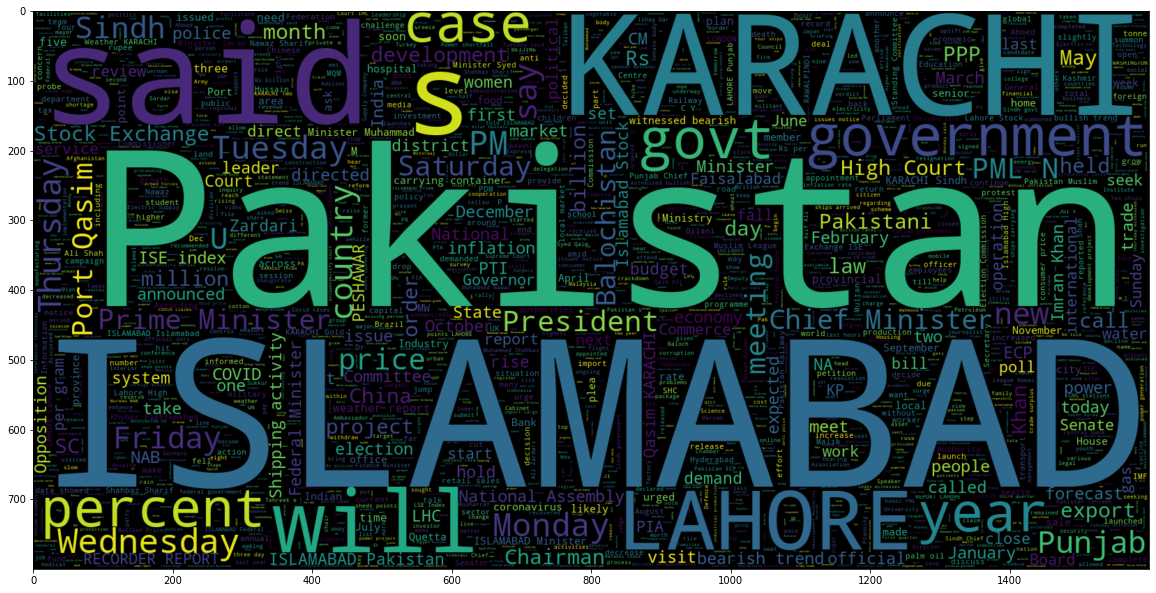

In [14]:
plt.figure(figsize = (20,20)) 
temp = df.sort_values(by=['Polarity'], ascending = False)
print(temp[count_pos:count_pos + count_ntl])
text = ' '.join(temp["News"][count_pos:count_pos + count_ntl])


    
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(text)
plt.imshow(wc , interpolation = 'bilinear')

### Negative Words

            Date                                               News  Polarity  \
9634  2020-09-02  PM’s efforts to punish corrupt mafia enters fi...        -1   
9901  2020-10-07  Fake bank accounts case: Senate deputy chairma...        -1   
9273  2020-07-15  MCC Quetta foils bid to smuggle hashish - KARA...        -1   
10011 2020-11-02  Modi has committed 'Himalayan blunder': Punjab...        -1   
10010 2020-11-02  Indian diplomat summoned over LoC violations -...        -1   
...          ...                                                ...       ...   
7520  2019-12-17  Musharraf’s verdict received with 'pain, angui...        -1   
7521  2019-12-17  High treason case: AG says verdict raises ques...        -1   
7522  2019-12-17  Pakistan placed 5th on Climate Risk Index due ...        -1   
7523  2019-12-17  IHC grants bail to Faryal Talpur in fake accou...        -1   
5257  2018-05-14  Police teams sent to KP to search for escaped ...        -1   

       Sentiment    neg    

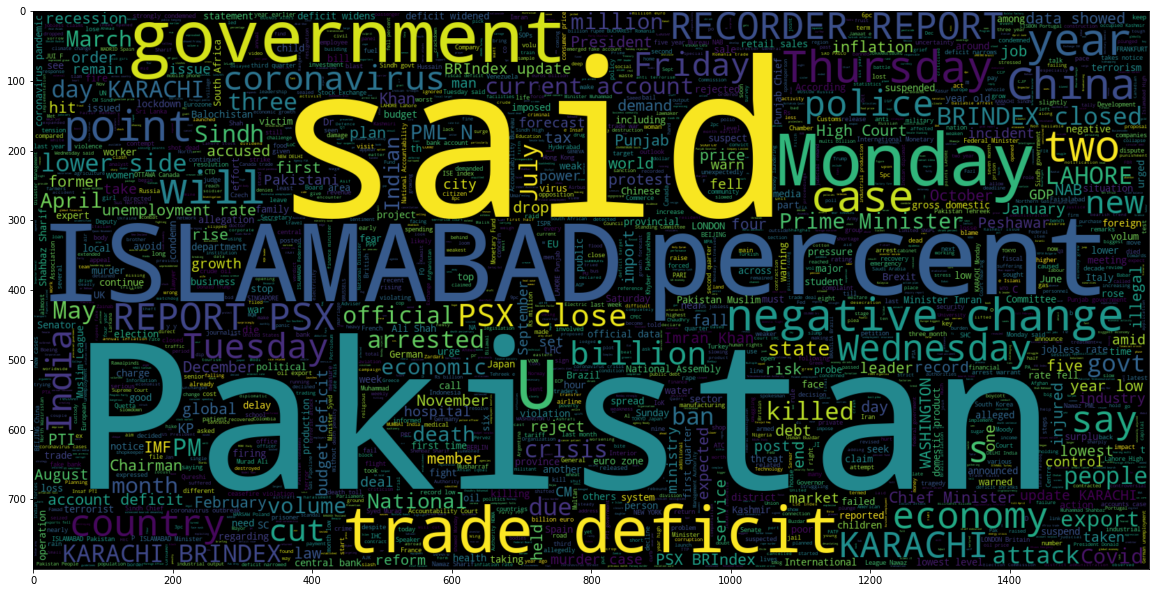

In [15]:
plt.figure(figsize = (20,20)) 
temp = df.sort_values(by=['Polarity'], ascending = False)
print(temp[count_pos + count_ntl:])
text = ' '.join(temp["News"][count_pos + count_ntl:])


    
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(text)
plt.imshow(wc , interpolation = 'bilinear')

## Train and Test Split

In [16]:
TRAIN_SIZE = 0.3
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 100

In [17]:
train_data, dump = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         random_state=7) # Splits Dataset into Training and Testing set
test_data = df.iloc[int(len(df)*0.3):]
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))
print(train_data)
print(test_data)

Train Data size: 3154
Test Data size 7361
           Date                                               News  Polarity  \
8245 2020-03-24  Sindh govt warns of imposing curfew - He said ...        -1   
8218 2020-03-21  LCCI stresses relaxation of CNIC condition til...         1   
8212 2020-03-21  SHC orders government to provide face masks to...         1   
5190 2018-04-13  ICCI for tapping solar energy potential to ove...         1   
2018 2014-10-24  Russian economy minister sees ‘big risks’ from...        -1   
...         ...                                                ...       ...   
919  2013-03-07  CM calls for timely completion of development ...         0   
4307 2017-06-02   A league of our own: How the PSL brand was built         0   
5699 2018-10-01  9kg heroin recovered from Czech woman at Lahor...        -1   
537  2012-04-17          Gilgit unrest: Authorities end day curfew         0   
9412 2020-08-06  Sheikh Rashid tests positive for Coronavirus -...         1  

`train_test_split` will shuffle the dataset and split it to gives training and testing dataset. It's important to shuffle our dataset before training.

In [18]:
train_data.describe()


,Polarity,Sentiment,neg,neu,pos,compound,Cum
count,3154.000000,3154.000000,3154.000000,3154.000000,3154.000000,3154.000000,3154.000000
mean,0.158529,0.158529,0.074951,0.832939,0.092104,0.081443,0.158529
std,0.792595,0.792595,0.121514,0.140209,0.108775,0.494268,0.792595
min,-1.000000,-1.000000,0.000000,0.194000,0.000000,-0.974700,-1.000000
25%,0.000000,0.000000,0.000000,0.754000,0.000000,-0.296000,0.000000
50%,0.000000,0.000000,0.000000,0.850000,0.069000,0.000000,0.000000
75%,1.000000,1.000000,0.130000,0.937750,0.155000,0.510600,1.000000
max,1.000000,1.000000,0.756000,1.000000,0.756000,0.955200,1.000000


# Tokenization


In [19]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['News'])

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Using TensorFlow backend.


Vocabulary Size : 10669


In [20]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data['News']),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data['News']),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (3154, 100)
Testing X Shape: (7361, 100)


### Label Encoding 
We are building the model to predict class in enocoded form (0 or 1 as this is a binary classification). We should encode our training labels to encodings.

In [21]:
from keras.utils.np_utils import to_categorical
train_labels = to_categorical(train_data['Polarity'], num_classes=3)
test_labels = to_categorical(test_data['Polarity'], num_classes=3)
#labels = np.argmax(labels, axis=1)
print(train_data[:10])
print(train_labels[:10])

           Date                                               News  Polarity  \
8245 2020-03-24  Sindh govt warns of imposing curfew - He said ...        -1   
8218 2020-03-21  LCCI stresses relaxation of CNIC condition til...         1   
8212 2020-03-21  SHC orders government to provide face masks to...         1   
5190 2018-04-13  ICCI for tapping solar energy potential to ove...         1   
2018 2014-10-24  Russian economy minister sees ‘big risks’ from...        -1   
1774 2014-08-12  LHC stays recovery of UOFS, DSS, NJS in electr...        -1   
1212 2013-11-01  Interior ministry demands more FC troops for Q...         0   
1183 2013-10-13  Singapore seen standing pat on monetary policy...         0   
224  2011-08-30                   SC tells Sindh govt to ‘wake up’         0   
8884 2020-05-28  Pakistan uses militant-tracking tech to hunt c...         1   

      Sentiment    neg    neu    pos  compound  Cum  
8245         -1  0.200  0.800  0.000   -0.5809   -1  
8218       

In [22]:
y_train = train_labels
y_test = test_labels
#y_train = y_train.reshape(-1,1)
#y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print(y_test)

y_train shape: (3154, 3)
y_test shape: (7361, 3)
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


# Word Emdedding


In [23]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove.6B.zip


In [24]:
GLOVE_EMB = 'glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 10
MODEL_PATH = 'best_model.hdf5'

In [25]:
embeddings_index = {}

f = open(GLOVE_EMB, encoding="utf8")
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [26]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [27]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


# Model Training - LSTM


In [28]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential

In [29]:
print((x_train.shape, y_train.shape, x_test.shape, y_test.shape))

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
#x = Sequential()
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5)(x)
x = Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(3, activation='sigmoid')(x)
print(outputs)
model = tf.keras.Model(sequence_input, outputs)
print(model.summary())

((3154, 100), (3154, 3), (7361, 100), (7361, 3))
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Tensor("dense_2/Sigmoid:0", shape=(?, 3), dtype=float32)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 300)          3200700   
_________________________________________________________________
spatial_dro



### Callbacks


In [30]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['acc'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [32]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Train on 3154 samples, validate on 7361 samples
Epoch 1/10
3154/3154 [==============================] - 25s 8ms/sample - loss: 0.5912 - acc: 0.6825 - val_loss: 0.5173 - val_acc: 0.7549
Epoch 2/10
3154/3154 [==============================] - 24s 7ms/sample - loss: 0.5226 - acc: 0.7422 - val_loss: 0.5002 - val_acc: 0.7768
Epoch 3/10
3154/3154 [==============================] - 24s 8ms/sample - loss: 0.4845 - acc: 0.7709 - val_loss: 0.4371 - val_acc: 0.8011
Epoch 4/10
3154/3154 [==============================] - 24s 8ms/sample - loss: 0.4412 - acc: 0.7939 - val_loss: 0.4178 - val_acc: 0.8087
Epoch 5/10
3154/3154 [==============================] - 24s 8ms/sample - loss: 0.3968 - acc: 0.8220 - val_loss: 0.4284 - val_acc: 0.8092
Epoch 6/10
3154/3154 [==============================] - 24s 8ms/sample - loss: 0.3525 - acc: 0.8462 - val_loss: 0.4188 - val_acc: 0.8128
Epoch 7/10
3154/3154 [==============================] - 24s 8ms/sample - loss: 0.3207 - acc: 0.8624 - val_loss: 0.4215 - val_acc: 

# Model Evaluation


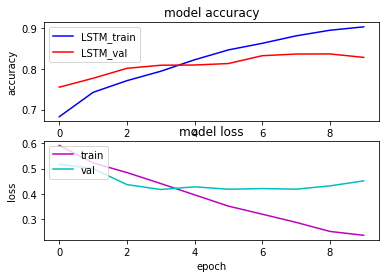

In [33]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['acc'], c= 'b')
at.plot(history.history['val_acc'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [34]:
def decode_sentiment(score):
    if score[0] > score[1] and score[0] > score[2]:
        print(score[0], '0\n---')
        return 0
    elif score[1] > score[0] and score[1] > score[2]:
        print(score[1], '1\n---')
        return 1
    elif score[2] > score[0] and score[2] > score[1]:
        print(score[2], '-1\n---')
        return -1

scores = model.predict(x_test, verbose=1, batch_size=10)
print(scores)
y_pred_1d = [decode_sentiment(score) for score in scores]

7361/7361 [==============================] - 21s 3ms/sample
[[0.37722832 0.06409708 0.5166046 ]
 [0.9830893  0.00617132 0.01266137]
 [0.11317194 0.85553277 0.02829707]
 ...
 [0.88951683 0.06276271 0.0338912 ]
 [0.51692927 0.33904657 0.23166636]
 [0.4796785  0.02190056 0.53731215]]
0.5166046 -1
---
0.9830893 0
---
0.85553277 1
---
0.81070954 1
---
0.7304335 1
---
0.88966686 0
---
0.92726064 1
---
0.90225565 1
---
0.54388535 0
---
0.73166436 1
---
0.927343 1
---
0.6295648 -1
---
0.92113596 -1
---
0.9982381 0
---
0.7087477 -1
---
0.9739186 -1
---
0.44156492 -1
---
0.5684165 1
---
0.82245946 0
---
0.84408563 -1
---
0.82171535 1
---
0.99106526 -1
---
0.7023827 0
---
0.9634268 1
---
0.97701806 0
---
0.9784478 0
---
0.49106967 0
---
0.87222147 1
---
0.9973893 0
---
0.9990392 0
---
0.6207771 -1
---
0.507769 1
---
0.89248693 1
---
0.6913533 1
---
0.9860126 1
---
0.9634219 1
---
0.6360154 1
---
0.99295545 1
---
0.9742526 1
---
0.9331156 0
---
0.8739294 0
---
0.9705991 1
---
0.4823333 1
---
0.999

In [35]:
len(y_pred_1d)

7361

### Confusion Matrix
Confusion Matrix provide a nice overlook at the model's performance in classification task

In [36]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

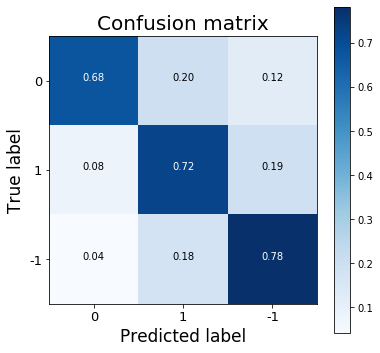

In [37]:
cnf_matrix = confusion_matrix(test_data['Polarity'].to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data['Polarity'].unique(), title="Confusion matrix")
plt.show()

### Classification Scores

In [38]:
print(classification_report(list(test_data['Polarity']), y_pred_1d))

              precision    recall  f1-score   support

          -1       0.82      0.68      0.74      2010
           0       0.54      0.72      0.62      1694
           1       0.83      0.78      0.81      3657

    accuracy                           0.74      7361
   macro avg       0.73      0.73      0.72      7361
weighted avg       0.76      0.74      0.75      7361



In [39]:
output = df.iloc[int(len(df)*TRAIN_SIZE):]

In [40]:
df.describe()

,Polarity,Sentiment,neg,neu,pos,compound,Cum
count,10515.000000,10515.000000,10515.000000,10515.000000,10515.000000,10515.000000,10515.000000
mean,0.167000,0.167000,0.076030,0.830364,0.093605,0.087019,0.167000
std,0.799274,0.799274,0.124271,0.140714,0.109041,0.501812,0.799274
min,-1.000000,-1.000000,0.000000,0.099000,0.000000,-0.979900,-1.000000
25%,0.000000,0.000000,0.000000,0.750000,0.000000,-0.296000,0.000000
50%,0.000000,0.000000,0.000000,0.845000,0.071000,0.000000,0.000000
75%,1.000000,1.000000,0.128000,0.934000,0.161000,0.510600,1.000000
max,1.000000,1.000000,0.821000,1.000000,0.773000,0.973200,1.000000


In [41]:
output.describe()

,Polarity,Sentiment,neg,neu,pos,compound,Cum
count,7361.000000,7361.000000,7361.000000,7361.00000,7361.000000,7361.000000,7361.000000
mean,0.223747,0.223747,0.075954,0.81971,0.104335,0.119167,0.223747
std,0.848471,0.848471,0.119996,0.12949,0.107856,0.536826,0.848471
min,-1.000000,-1.000000,0.000000,0.09900,0.000000,-0.979900,-1.000000
25%,-1.000000,-1.000000,0.000000,0.74700,0.000000,-0.381800,-1.000000
50%,0.000000,0.000000,0.000000,0.83300,0.088000,0.296000,0.000000
75%,1.000000,1.000000,0.131000,0.90900,0.172000,0.557400,1.000000
max,1.000000,1.000000,0.806000,1.00000,0.773000,0.973200,1.000000


In [42]:
output['Pred'] = y_pred_1d
output.head()

C:\Users\CZ\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Date,News,Polarity,Sentiment,neg,neu,pos,compound,Cum,Pred
3154,2016-02-05,KP CM directs immediate arrest of accused invo...,0,0,0.139,0.783,0.078,-0.2500,0,-1
3155,2016-02-05,Australian entrepreneur reveals himself as Bit...,0,0,0.000,1.000,0.000,0.0000,0,0
3156,2016-02-06,AJK to be blessed with first ever largest priv...,1,1,0.000,0.891,0.109,0.5994,1,1
3157,2016-02-06,South Korea's Q1 growth slightly higher at 0.5...,1,1,0.000,0.915,0.085,0.3818,1,1
3158,2016-02-06,Federal budget to help revive industrial secto...,1,1,0.000,0.819,0.181,0.6249,1,1


In [43]:
output.head()

,Date,News,Polarity,Sentiment,neg,neu,pos,compound,Cum,Pred
3154,2016-02-05,KP CM directs immediate arrest of accused invo...,0,0,0.139,0.783,0.078,-0.2500,0,-1
3155,2016-02-05,Australian entrepreneur reveals himself as Bit...,0,0,0.000,1.000,0.000,0.0000,0,0
3156,2016-02-06,AJK to be blessed with first ever largest priv...,1,1,0.000,0.891,0.109,0.5994,1,1
3157,2016-02-06,South Korea's Q1 growth slightly higher at 0.5...,1,1,0.000,0.915,0.085,0.3818,1,1
3158,2016-02-06,Federal budget to help revive industrial secto...,1,1,0.000,0.819,0.181,0.6249,1,1


In [44]:
output = output.reset_index(drop=True)
output.head()


,Date,News,Polarity,Sentiment,neg,neu,pos,compound,Cum,Pred
0,2016-02-05,KP CM directs immediate arrest of accused invo...,0,0,0.139,0.783,0.078,-0.2500,0,-1
1,2016-02-05,Australian entrepreneur reveals himself as Bit...,0,0,0.000,1.000,0.000,0.0000,0,0
2,2016-02-06,AJK to be blessed with first ever largest priv...,1,1,0.000,0.891,0.109,0.5994,1,1
3,2016-02-06,South Korea's Q1 growth slightly higher at 0.5...,1,1,0.000,0.915,0.085,0.3818,1,1
4,2016-02-06,Federal budget to help revive industrial secto...,1,1,0.000,0.819,0.181,0.6249,1,1


In [45]:
pred = pd.read_csv('predictions-M1+TI.csv')
pred['Date'] = pd.to_datetime(pred['Date']) 
pred.head()

,Unnamed: 0,Unnamed: 0.1,Date,Predicted Price,21 SMA,50 SMA,100 SMA,200 SMA,RSI,21-avg volume,Upper BBand,Middle BBand,Lower BBand,52-week high,52-week low,MACD,Close
0,0,0,2015-01-06,569.61523,591.197386,587.600426,525.348152,477.123198,40.678552,44733.333333,624.841681,587.234645,549.627609,708.8778,283.5191,Bearish,559.9417
1,1,1,2015-01-07,563.69210,585.986010,588.991264,526.909789,478.264606,41.067064,44521.428571,615.062770,583.438470,551.814170,708.8778,283.5191,Bearish,561.0133
2,2,2,2015-01-08,561.26184,582.312343,590.208248,528.279730,479.395956,40.739000,44395.238095,612.758822,581.173325,549.587828,708.8778,283.5191,Bearish,559.7898
3,3,3,2015-01-09,565.08560,579.876686,591.427470,529.625085,480.414978,39.130526,43442.857143,613.796652,580.128515,546.460378,708.8778,283.5191,Bearish,553.9439
4,4,4,2015-01-12,562.80490,579.567848,592.934904,531.173942,481.491159,44.905225,41935.714286,610.840860,578.427150,546.013440,708.8778,283.5191,Bearish,568.3545


In [46]:
start_date = output['Date'][0]
end_date = pred['Date'][len(pred)-1]

start = pred.index[pred['Date'] == start_date].to_list()[0]
pred = pred.iloc[start:]
pred.head()

,Unnamed: 0,Unnamed: 0.1,Date,Predicted Price,21 SMA,50 SMA,100 SMA,200 SMA,RSI,21-avg volume,Upper BBand,Middle BBand,Lower BBand,52-week high,52-week low,MACD,Close
283,283,283,2016-02-05,533.11273,507.525152,519.098944,536.939936,536.254726,65.805443,4900.000000,543.609544,506.468375,469.327206,588.5237,378.7857,Bullish,546.7055
284,284,284,2016-02-08,555.74480,508.896100,519.760506,537.195101,536.725971,69.197385,5145.238095,551.163998,508.260995,465.357992,588.5237,378.7857,Bullish,557.4506
285,285,285,2016-02-09,542.00714,510.268995,520.442526,537.380050,537.076076,64.682093,5709.523810,557.078174,510.413280,463.748386,588.5237,378.7857,Bullish,550.4290
286,286,286,2016-02-10,551.68770,511.827776,520.917994,537.314581,537.258181,58.631611,8183.333333,559.987064,511.599900,463.212736,588.5237,378.7857,Bullish,540.1177
287,287,287,2016-02-11,546.17530,512.352305,521.139116,537.121939,537.434014,52.152077,11309.523810,561.292362,513.435890,465.579418,588.5237,378.7857,Bullish,527.4004


In [47]:

end = output.index[output['Date'] == end_date].to_list()[0]
output = output.iloc[:end]
output.head()

,Date,News,Polarity,Sentiment,neg,neu,pos,compound,Cum,Pred
0,2016-02-05,KP CM directs immediate arrest of accused invo...,0,0,0.139,0.783,0.078,-0.2500,0,-1
1,2016-02-05,Australian entrepreneur reveals himself as Bit...,0,0,0.000,1.000,0.000,0.0000,0,0
2,2016-02-06,AJK to be blessed with first ever largest priv...,1,1,0.000,0.891,0.109,0.5994,1,1
3,2016-02-06,South Korea's Q1 growth slightly higher at 0.5...,1,1,0.000,0.915,0.085,0.3818,1,1
4,2016-02-06,Federal budget to help revive industrial secto...,1,1,0.000,0.819,0.181,0.6249,1,1


In [48]:
len(pred)

1220

In [49]:
output.tail()

,Date,News,Polarity,Sentiment,neg,neu,pos,compound,Cum,Pred
6747,2020-10-07,Fake bank accounts case: Senate deputy chairma...,-1,-1,0.124,0.876,0.000,-0.4767,-1,-1
6748,2020-10-07,Regularisation of daily wage workers demanded ...,-1,-1,0.160,0.840,0.000,-0.4215,-1,-1
6749,2020-10-07,FM expresses sorrow over loss of lives in Nepa...,-1,-1,0.198,0.679,0.122,-0.4215,-1,-1
6750,2020-10-07,Power outage continues in Karachi - According ...,-1,-1,0.107,0.893,0.000,-0.4767,-1,-1
6751,2020-10-07,Pakistan ensuring completion of FATF Action Pl...,-1,-1,0.228,0.618,0.154,-0.3542,-1,-1


In [50]:
temp.head()

,Date,News,Polarity,Sentiment,neg,neu,pos,compound,Cum
2770,2015-08-26,Stock wobbles persist despite China rate cut -...,1,1,0.0,0.623,0.377,0.8787,1
3602,2016-07-03,"Saudi investors keen in investment, joint vent...",1,1,0.0,0.809,0.191,0.6369,1
6966,2019-11-10,AkzoNobel introduces Dulux weathershield - Akz...,1,1,0.0,0.865,0.135,0.6808,1
6967,2019-11-10,Multimodal transport service via train initiat...,1,1,0.0,0.930,0.070,0.4019,1
3620,2016-07-11,Rice export orders to bring relief to farmers ...,1,1,0.0,0.807,0.193,0.7351,1


In [51]:
temp = output.groupby(['Date'], as_index = False).mean()

pred['Score'] = [0 for i in range(len(pred))]

for i in range(len(temp)):
    
    date = temp['Date'][i]
    
    index = pred.index[pred['Date'] == date]
    
    pred['Score'][index] = temp['Pred'][i]
    
pred.tail(25)
    
    
    
    
    
    
    

C:\Users\CZ\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,Unnamed: 0,Unnamed: 0.1,Date,Predicted Price,21 SMA,50 SMA,100 SMA,200 SMA,RSI,21-avg volume,Upper BBand,Middle BBand,Lower BBand,52-week high,52-week low,MACD,Close,Score
1478,1478,1478,2020-09-04,752.84560,687.700343,643.241560,567.073190,477.278625,83.101788,117204.761905,784.008362,691.591945,599.175528,758.3863,297.952,Bullish,754.68,0.000000
1479,1479,1479,2020-09-07,756.36145,694.240424,645.322038,570.144430,478.813570,77.583536,120376.190476,786.195345,698.339410,610.483475,758.3863,297.952,Bullish,747.21,0.166667
1480,1480,1480,2020-09-08,757.45984,700.762771,647.305056,573.474351,480.453554,78.008797,119252.380952,789.119477,704.220110,619.320743,758.3863,297.952,Bullish,749.23,0.000000
1481,1481,1481,2020-09-09,748.66270,705.925819,649.421764,576.649690,482.033220,71.374703,120173.809524,788.784107,709.703080,630.622053,758.3863,297.952,Bullish,740.04,0.000000
1482,1482,1482,2020-09-10,740.93190,712.548171,652.306694,580.079109,483.782356,77.862888,117819.047619,793.569862,715.793210,638.016558,758.3863,297.952,Bullish,769.45,0.125000
1483,1483,1483,2020-09-11,758.83760,717.426390,654.784226,583.302585,485.432185,67.083717,121742.857143,793.377374,720.915340,648.453306,769.4500,297.952,Bearish,750.09,0.000000
1484,1484,1484,2020-09-14,754.41170,723.255086,657.659978,586.763366,487.165710,71.469123,113685.714286,798.692385,725.152890,651.613395,769.4500,297.952,Bearish,770.05,-0.562500
1485,1485,1485,2020-09-15,757.15770,727.596086,660.728054,590.370698,488.828775,72.725827,110823.809524,803.419357,730.125695,656.832033,770.0500,297.952,Bearish,776.46,0.666667
1486,1486,1486,2020-09-16,769.01950,731.924948,663.610816,593.835441,490.447355,68.398150,87971.428571,804.851169,734.920050,664.988931,776.4600,297.952,Bearish,767.91,-0.333333
1487,1487,1487,2020-09-17,768.45640,736.246238,666.479024,597.068646,492.067332,65.860831,86659.523810,804.731676,739.229435,673.727194,776.4600,297.952,Bearish,762.77,-0.500000


In [54]:
pred.describe()

,Unnamed: 0,Unnamed: 0.1,Predicted Price,21 SMA,50 SMA,100 SMA,200 SMA,RSI,21-avg volume,Upper BBand,Middle BBand,Lower BBand,52-week high,52-week low,Close,Score
count,1220.000000,1220.000000,1220.000000,1220.000000,1220.000000,1220.000000,1220.000000,1220.000000,1220.000000,1220.000000,1220.000000,1220.000000,1220.000000,1220.000000,1220.000000,1220.000000
mean,892.500000,892.500000,595.370481,594.335526,591.737429,589.647618,591.803424,50.641552,24757.673419,633.563616,594.443727,555.323838,751.273545,458.075973,596.435487,0.073820
std,352.327972,352.327972,146.272711,144.756724,141.553004,136.351171,124.986674,14.727982,26299.345835,148.214235,144.875690,144.442100,135.846504,109.632079,147.102959,0.505605
min,283.000000,283.000000,301.873600,314.568471,319.318274,340.871358,364.150081,17.881905,621.428571,331.253628,312.986035,255.666703,469.768400,297.952000,297.952000,-1.000000
25%,587.750000,587.750000,505.282263,510.513451,520.799127,527.581212,520.592888,40.193838,5545.238095,546.497512,511.247299,451.193318,655.928900,343.423025,506.312125,0.000000
50%,892.500000,892.500000,607.984450,605.149271,603.920737,588.254588,587.711743,50.345344,13902.380952,646.890362,604.788472,565.564949,704.574600,478.740700,608.630800,0.000000
75%,1197.250000,1197.250000,685.207925,687.348029,684.444697,665.226236,674.195879,60.751006,36071.428571,719.656685,687.292867,650.209290,873.122600,548.633900,688.026200,0.400000
max,1502.000000,1502.000000,959.511960,890.957310,859.307754,840.099523,814.862280,87.740593,132909.523810,979.188809,892.893660,835.165337,957.071100,663.024100,957.071100,1.000000


In [53]:
pred.to_csv(path_or_buf = 'Predictions--M2+TI' + '.csv', index = False) #Save dataframe as CSV